In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import numpy as np


from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
from tqdm import tqdm

import torch
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau


from model import ModelArgs, TransformerForSequenceClassification


import os

device = "cuda" if torch.cuda.is_available() else 'cpu'

In [2]:
df = pd.read_csv("../data/data_with_scaled_grades.csv")
df = df[["essay", "scaled_grade"]]
def let_to_num(row):
    k = {"F": 0, "D": 1, "C": 2, "B": 3, "A": 4}
    return k[row]


df["num_grade"] = df["scaled_grade"].apply(let_to_num)

tr = round(len(df) * 0.8)
val = round(len(df) * 0.1)

df_train = df[0:tr]
df_val = df[tr : tr + val].reset_index(drop=True)
df_test = df[tr + val :].reset_index(drop=True)

In [3]:
def chunk_and_embed(text,tokenizer,model, chunk_size=512):
    tokens = tokenizer.tokenize(text)
    max_chunk_size = chunk_size - 2 
    chunked_tokens = [tokens[i:i + max_chunk_size] for i in range(0, len(tokens), max_chunk_size)]

 
    chunked_input_ids = [tokenizer.convert_tokens_to_ids(['[CLS]'] + chunk + ['[SEP]']) for chunk in chunked_tokens]

    ins = [torch.tensor(x) for x in chunked_input_ids]

    with torch.no_grad():
        out = [model(input_ids = ins[x].unsqueeze(0)).last_hidden_state for x in range(len(ins))]


    return torch.cat(out,dim=1).squeeze(0)


In [4]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
embeddings_model = BertModel.from_pretrained('bert-base-uncased')

In [7]:
class EssayDataset(Dataset):
    def __init__(self, essay_df, tokenizer,model):

        self.essays = essay_df["essay"].to_list()
        self.scores = essay_df["num_grade"]
        self.model = model
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.essays)

    def __getitem__(self, index):
        embeddings = chunk_and_embed(self.essays[index],self.tokenizer,self.model)

        score = self.scores[index]

    

        return {
            embeddings,
            torch.tensor([score], dtype=torch.long),
        }

    def num_classes(self):
        return pd.Series(self.scores).nunique()

    def __repr__(self) -> str:
        return f"Dataset with {len(self)} essays"


ds_train = EssayDataset(df_train, tokenizer,embeddings_model)
ds_val = EssayDataset(df_val, tokenizer,embeddings_model)

In [8]:
config = ModelArgs(
    dim=768,
    n_layers=42,
    n_heads=48,
    n_classes=ds_train.num_classes(),
)

model = TransformerForSequenceClassification(config)
print(f"{model.params():,}")

state_dict = torch.load('weights/model_epoch_5.pt')
model.load_state_dict(state_dict)

model = model.to(device)


297,340,421


In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer,mode='min',factor=0.1,patience=2)

from torch.nn.utils.rnn import pad_sequence
import torch


def collate_batch(batch):
    data, labels = zip(*batch)

    padded_data = pad_sequence(
        data, batch_first=True, padding_value=0
    )  

    labels = torch.tensor(labels)

    return padded_data, labels

train_dataloader = DataLoader(ds_train, batch_size=1, shuffle=True, collate_fn=collate_batch)
val_dataloader = DataLoader(ds_val, batch_size=1, shuffle=True, collate_fn=collate_batch)


In [8]:
start_epoch = 1
end_epoch = 5
batch_losses = []
val_losses = []
val_accuracies = []
for epoch in range(start_epoch,end_epoch):
    torch.cuda.empty_cache()
    model.train()
    batch_iterator = tqdm(train_dataloader, desc=f"Processing Epoch {epoch:02d}")
    running_loss = 0.0
    for batch_idx,batch in enumerate(batch_iterator):
        tokens,labels = batch[0].to(device),batch[1].to(device)
        out = model(tokens)
        loss = loss_fn(out, labels)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        batch_losses.append(running_loss /( 1 if batch_idx == 0 else batch_idx))

        running_loss += loss.item()

        batch_iterator.set_postfix(loss=running_loss /( 1 if batch_idx == 0 else batch_idx))
    
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        val_iterator = tqdm(val_dataloader,desc=f"Validating Epoch {epoch:02d}")
        for idx,batch in enumerate(val_iterator):
            tokens,labels = batch[0].to(device),batch[1].to(device)
            out = model(tokens)
            loss = loss_fn(out,labels)

            val_loss += loss.item()

            preds = torch.argmax(out, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

            preds = torch.argmax(out, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

            val_losses.append(loss.item())
            val_accuracies.append(val_correct / val_total)

    scheduler.step(val_loss)


    val_loss /= len(val_dataloader)
    val_accuracy = val_correct / val_total

    torch.save(model.state_dict(), os.path.join('weights', f'model_epoch_{epoch+1}.pt'))

    print(
        f"Epoch [{epoch+1}/{end_epoch}], Train Loss: {running_loss / len(train_dataloader):.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}"
    )


Validating Epoch 01: 100%|██████████| 1298/1298 [01:35<00:00, 13.58it/s]


Epoch [2/5], Train Loss: 1.0784, Val Loss: 1.4535, Val Accuracy: 0.4615


Validating Epoch 02: 100%|██████████| 1298/1298 [01:34<00:00, 13.67it/s]


Epoch [3/5], Train Loss: 0.8526, Val Loss: 1.4994, Val Accuracy: 0.4453


Validating Epoch 03: 100%|██████████| 1298/1298 [01:35<00:00, 13.61it/s]


Epoch [4/5], Train Loss: 0.8058, Val Loss: 1.4463, Val Accuracy: 0.4407


Validating Epoch 04: 100%|██████████| 1298/1298 [01:34<00:00, 13.69it/s]


Epoch [5/5], Train Loss: 0.7908, Val Loss: 1.3371, Val Accuracy: 0.4700


In [10]:
ds_test = EssayDataset(df_test, tokenizer,embeddings_model)

In [11]:
preds = []
labels = []
for i in tqdm(range(len(ds_test))):
    tokens, label = ds_test[i]
    out = model(tokens.unsqueeze(0).to(device))
    pred = torch.argmax(out)
    out = out.to('cpu')
    del out

    preds.append(pred)
    labels.append(label)


100%|██████████| 1297/1297 [03:55<00:00,  5.52it/s]


In [12]:
preds = torch.stack(preds).cpu().numpy()
labels = torch.stack(labels).squeeze().numpy()

from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(labels,preds)

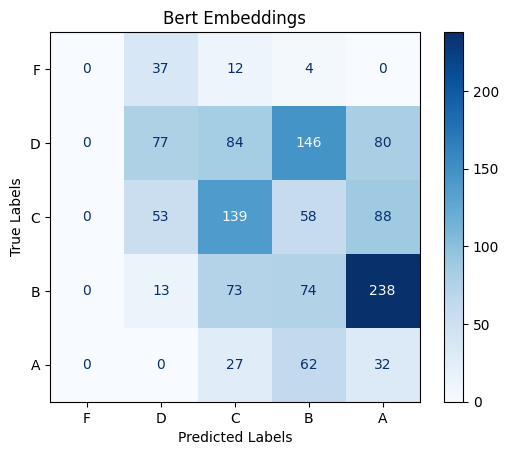

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=["F", "D", "C", "B", "A"])

fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, ax=ax)  

ax.set_title('Bert Embeddings')

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

plt.show()

In [14]:
def quadratic_weighted_kappa(conf_matrix):

    w = np.zeros_like(conf_matrix, dtype=float)

    num_categories = conf_matrix.shape[0] 

    for i in range(num_categories):
        for j in range(num_categories):
            w[i, j] = ((i - j) / (num_categories - 1)) ** 2


    total_observations = conf_matrix.sum()

    row_totals = conf_matrix.sum(axis=1)

    col_totals = conf_matrix.sum(axis=0)

    e = np.zeros_like(conf_matrix, dtype=float)

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            e[i, j] = (row_totals[i] * col_totals[j]) / total_observations


    num = 0
    den = 0
    for i in range(num_categories):
        for j in range(num_categories):
            num += (w[i,j] * conf_matrix[i,j])
            den += (w[i,j] * e[i,j])

    return 1 - (num/den)

In [15]:
quadratic_weighted_kappa(conf_matrix)

0.28860610601679115

In [16]:
from sklearn.metrics import classification_report
report = classification_report(labels, preds, target_names=["f","d","c",'b','a'])


/home/luke/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luke/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luke/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
print(report)

              precision    recall  f1-score   support

           f       0.00      0.00      0.00        53
           d       0.43      0.20      0.27       387
           c       0.41      0.41      0.41       338
           b       0.22      0.19      0.20       398
           a       0.07      0.26      0.11       121

    accuracy                           0.25      1297
   macro avg       0.23      0.21      0.20      1297
weighted avg       0.31      0.25      0.26      1297

